## Imports

In [ ]:
!pip install --upgrade pip setuptools wheel Cython


In [ ]:
!pip install prophet


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import seaborn as sns
from tqdm import tqdm

c:\Users\Louise\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chargement des données 

In [4]:
file_path = "../data/dataset.csv"
df = pd.read_csv(file_path)
df.head()

,datehour,station,lat,lon,name,cluster,reconstructed,disabled,capacity,bikes,delta,hour,weekday,weekend,holiday,preholiday,temp,precip,gel,vent
0,2024-12-05 00:00:00,35600927,48.863937,2.276595,Mairie du 16ème,35,True,False,34,2,1,0,3,0,0,0,5.6,0.0,0,1.8
1,2024-12-05 00:00:00,18523627466,48.923307,2.384729,Suzanne Masson,28,True,False,36,3,1,0,3,0,0,0,5.6,0.0,0,1.8
2,2024-12-05 00:00:00,101024234,48.828375,2.384274,Quai Panhard et Levassor,30,True,False,57,5,0,0,3,0,0,0,5.6,0.0,0,1.8
3,2024-12-05 00:00:00,6354,48.820507,2.351342,Gouthière - Poterne des Peupliers,5,True,False,33,1,0,0,3,0,0,0,5.6,0.0,0,1.8
4,2024-12-05 00:00:00,486750405,48.897918,2.336487,Ney - Porte de Montmartre,33,True,False,18,3,1,0,3,0,0,0,5.6,0.0,0,1.8


In [ ]:
df['datehour'] = pd.to_datetime(df['datehour'])

df_prophet = df.rename(columns={'datehour': 'ds', 'delta': 'y'})

df_prophet['hour'] = df_prophet['ds'].dt.hour
df_prophet['day'] = df_prophet['ds'].dt.day
df_prophet['month'] = df_prophet['ds'].dt.month
df_prophet['dayofweek'] = df_prophet['ds'].dt.dayofweek



In [6]:
df_prophet.head(20)

,ds,station,lat,lon,name,cluster,reconstructed,disabled,capacity,bikes,...,weekend,holiday,preholiday,temp,precip,gel,vent,day,month,dayofweek
0,2024-12-05,35600927,48.863937,2.276595,Mairie du 16ème,35,True,False,34,2,...,0,0,0,5.6,0.0,0,1.8,5,12,3
1,2024-12-05,18523627466,48.923307,2.384729,Suzanne Masson,28,True,False,36,3,...,0,0,0,5.6,0.0,0,1.8,5,12,3
2,2024-12-05,101024234,48.828375,2.384274,Quai Panhard et Levassor,30,True,False,57,5,...,0,0,0,5.6,0.0,0,1.8,5,12,3
3,2024-12-05,6354,48.820507,2.351342,Gouthière - Poterne des Peupliers,5,True,False,33,1,...,0,0,0,5.6,0.0,0,1.8,5,12,3
4,2024-12-05,486750405,48.897918,2.336487,Ney - Porte de Montmartre,33,True,False,18,3,...,0,0,0,5.6,0.0,0,1.8,5,12,3
5,2024-12-05,16379269732,48.830475,2.261614,Président Roosevelt - Rouget de Lisle,21,True,False,40,5,...,0,0,0,5.6,0.0,0,1.8,5,12,3
6,2024-12-05,76488849,48.836379,2.372340,Fernand Braudel - Vincent Auriol,30,True,False,36,4,...,0,0,0,5.6,0.0,0,1.8,5,12,3
7,2024-12-05,213695073,48.880052,2.400865,Hôpital Robert Debré,36,True,False,29,1,...,0,0,0,5.6,0.0,0,1.8,5,12,3
8,2024-12-05,35908,48.848191,2.341832,Cujas - Saint-Michel,48,True,False,19,1,...,0,0,0,5.6,0.0,0,1.8,5,12,3
9,2024-12-05,210751059,48.835405,2.358218,Hôpital - Campo-Formio,48,True,False,11,4,...,0,0,0,5.6,0.0,0,1.8,5,12,3


In [16]:
def train_by_station(df, station_id, periode_prediction=7*24):
    """
    Trains a Prophet model for a specific station using a time-based.

    Args:
        df: Preprocessed DataFrame
        station_id: ID of the station to predict
        periode_prediction: Number of hours to predict (default is 7 days)

    Returns:
        model: Trained Prophet model
        forecast: Forecast DataFrame
        mae: Mean Absolute Error
        rmse: Root Mean Squared Error
    """

    # Filter the dataset for the selected station
    df_station = df[df['station'] == station_id].copy()

    if len(df_station) == 0:
        print(f"No data available for station {station_id}")
        return None, None, None, None

    # Time-based split (no shuffle to preserve temporal order)
    df_train, df_test = train_test_split(df_station, test_size=0.2, shuffle=False)
    print(f"Training on {len(df_train)} rows, testing on {len(df_test)} rows.")

    # Define the list of regressors
    regressors = ['hour', 'weekday', 'weekend']
    regressors_available = [r for r in regressors if r in df_train.columns or r in ['hour', 'weekday', 'weekend']]

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=20,
        daily_seasonality=True,
        seasonality_mode='additive',
        interval_width=0.99,
    )

    for reg in regressors_available:
        model.add_regressor(reg)

    needed_columns = ['ds', 'y'] + regressors_available
    df_train_prophet = df_train[needed_columns].copy()

    model.fit(df_train_prophet)

    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=periode_prediction, freq='H')

    for reg in regressors_available:
        if reg in df_train.columns:
            future[reg] = df_station[reg].reindex(future.index, method='ffill').fillna(df_train[reg].mean())
        else:
            if reg == 'hour':
                future[reg] = future['ds'].dt.hour
            elif reg == 'weekday':
                future[reg] = (future['ds'].dt.dayofweek < 5).astype(int)
            elif reg == 'weekend':
                future[reg] = (future['ds'].dt.dayofweek >= 5).astype(int)

    # Make predictions
    forecast = model.predict(future)

    forecast_test = forecast[forecast['ds'].isin(df_test['ds'])]

    if len(forecast_test) != len(df_test):
        print(f"Warning: Mismatch between forecast and test set sizes. Forecast: {len(forecast_test)}, Test: {len(df_test)}")
        df_test = df_test[df_test['ds'].isin(forecast_test['ds'])]

    y_true = df_test['y'].values
    y_pred = forecast_test['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return model, forecast, mae, rmse


In [18]:
def plot_predictions(df_station, forecast, station_id):
    """
    Displays predictions vs. actual values for a specific station.
    """
    plt.figure(figsize=(12, 8))

    # Plot actual observed values
    plt.plot(df_station['ds'], df_station['y'], 'ko', markersize=2, label='Observed')

    # Plot predicted values
    plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Prediction')

    # Add confidence interval
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                     color='blue', alpha=0.2, label='95% confidence interval')


    plt.title(f'Predicted bike delta for station {station_id}')
    plt.xlabel('Date')
    plt.ylabel('Bike delta')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    return plt


In [14]:
def analyze_components(model, forecast):
    """
    Analyzes the components of the Prophet model.
    """
    fig = model.plot_components(forecast)
    return fig

In [ ]:
def train_multiple_station_models(df, stations=None, top_n=5):
    """
    Trains Prophet models for multiple stations.
    
    Args:
        df: DataFrame with preprocessed data
        stations: List of station IDs to predict (if None, use top_n)
        top_n: Number of most active stations to predict (if stations=None)
    
    Returns:
        results: Dictionary of results per station
    """
    if stations is None:
        # Identify the most active stations in terms of transactions
        station_counts = df['station'].value_counts()
        stations = station_counts.head(top_n).index.tolist()
    
    results = {}
    
    for station_id in tqdm(stations, desc="Training models per station"):
        model, forecast, mae, rmse = train_by_station(df, station_id)
        
        if model is not None:
            results[station_id] = {
                'model': model,
                'forecast': forecast,
                'mae': mae,
                'rmse': rmse
            }
            
            print(f"Station {station_id}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")
    
    return results


In [ ]:
def compare_performance(results):
    """
    Compares the performance of models across different stations.
    
    Args:
        results: Dictionary containing the model results for each station.
    
    Returns:
        fig: The plot visualizing the performance comparison.
        metrics_df: DataFrame with MAE and RMSE for each station.
    """
    stations = list(results.keys())
    mae_values = [results[s]['mae'] for s in stations]
    rmse_values = [results[s]['rmse'] for s in stations]
    
    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Station': stations,
        'MAE': mae_values,
        'RMSE': rmse_values
    })
    
    # Sort by MAE
    metrics_df = metrics_df.sort_values('MAE')
    
    # Visualize the performance
    plt.figure(figsize=(12, 8))
    
    # Plot the MAE
    plt.subplot(2, 1, 1)
    sns.barplot(x='Station', y='MAE', data=metrics_df)
    plt.title('Mean Absolute Error (MAE) by Station')
    plt.xticks(rotation=45)
    
    # Plot the RMSE
    plt.subplot(2, 1, 2)
    sns.barplot(x='Station', y='RMSE', data=metrics_df)
    plt.title('Root Mean Squared Error (RMSE) by Station')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    return plt, metrics_df


Entrainement des modèles par station:   0%|          | 0/5 [00:00<?, ?it/s]

Entrainement sur 1881 observations, Test sur 471 observations.


15:43:20 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
Entrainement des modèles par station:  20%|██        | 1/5 [00:00<00:03,  1.01it/s]

Avertissement : Ajustement des données de test. Prévisions: 168, Test: 471
Station 35600927: MAE = 1.48, RMSE = 2.50
Entrainement sur 1881 observations, Test sur 471 observations.


15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
Entrainement des modèles par station:  40%|████      | 2/5 [00:02<00:03,  1.06s/it]

Avertissement : Ajustement des données de test. Prévisions: 168, Test: 471
Station 39256416: MAE = 3.72, RMSE = 4.93
Entrainement sur 1881 observations, Test sur 471 observations.


15:43:22 - cmdstanpy - INFO - Chain [1] start processing
15:43:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
Entrainement des modèles par station:  60%|██████    | 3/5 [00:03<00:02,  1.01s/it]

Avertissement : Ajustement des données de test. Prévisions: 168, Test: 471
Station 97705710: MAE = 2.69, RMSE = 3.78
Entrainement sur 1881 observations, Test sur 471 observations.


15:43:23 - cmdstanpy - INFO - Chain [1] start processing
15:43:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
Entrainement des modèles par station:  80%|████████  | 4/5 [00:04<00:01,  1.07s/it]

Avertissement : Ajustement des données de test. Prévisions: 168, Test: 471
Station 129001431: MAE = 1.62, RMSE = 2.11
Entrainement sur 1881 observations, Test sur 471 observations.


15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
Entrainement des modèles par station: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]

Avertissement : Ajustement des données de test. Prévisions: 168, Test: 471
Station 875078767: MAE = 1.58, RMSE = 2.06



c:\Users\Louise\miniconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behav

Analyse terminée avec succès!


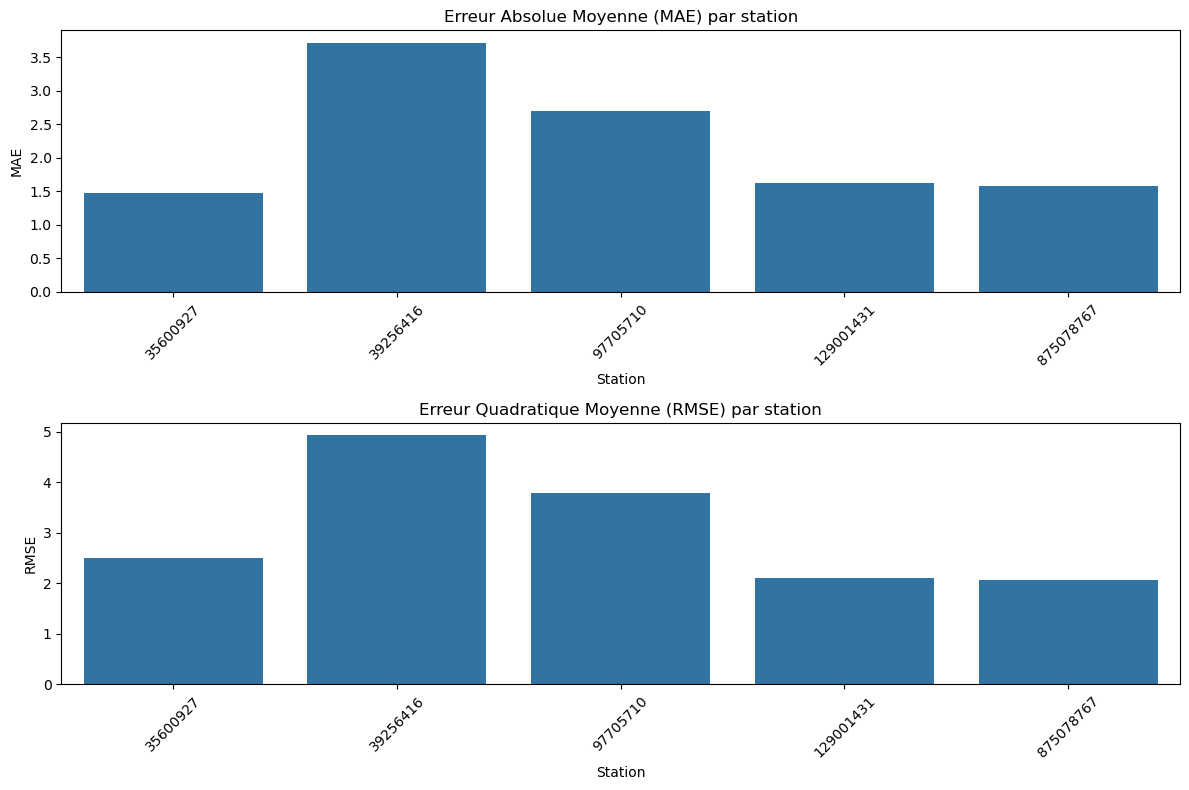

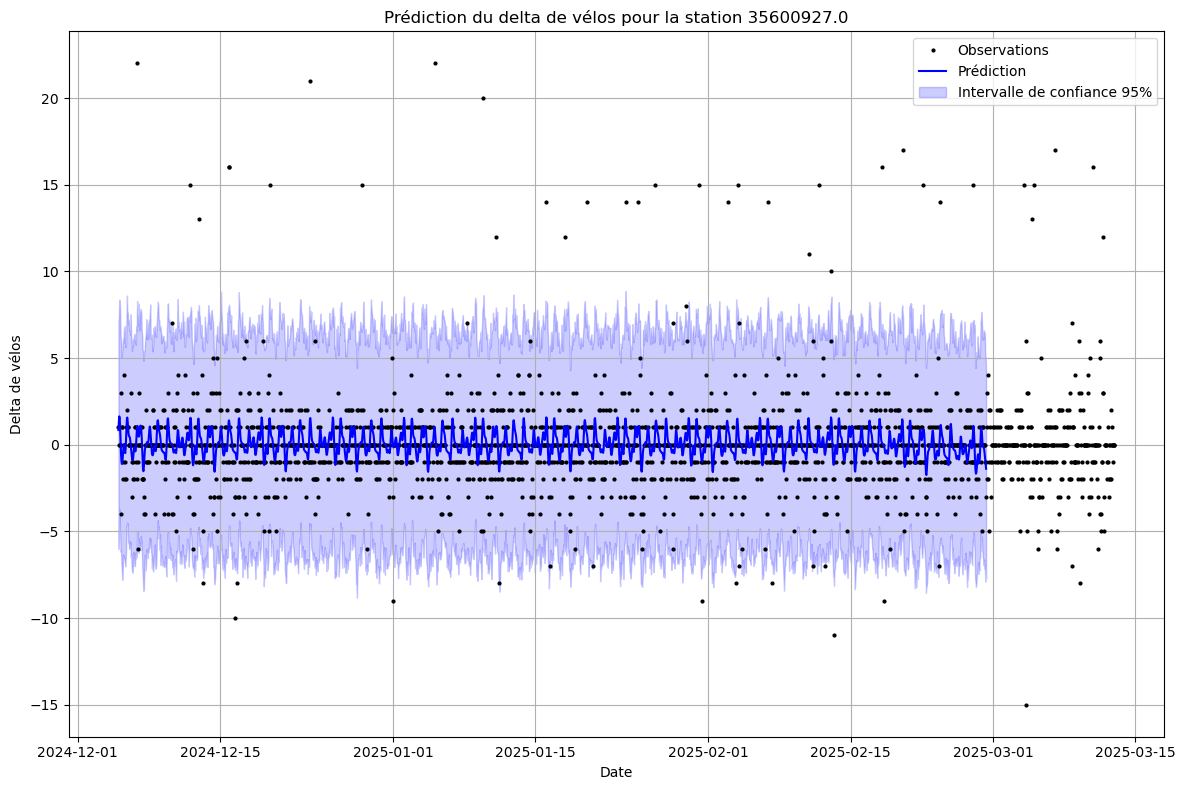

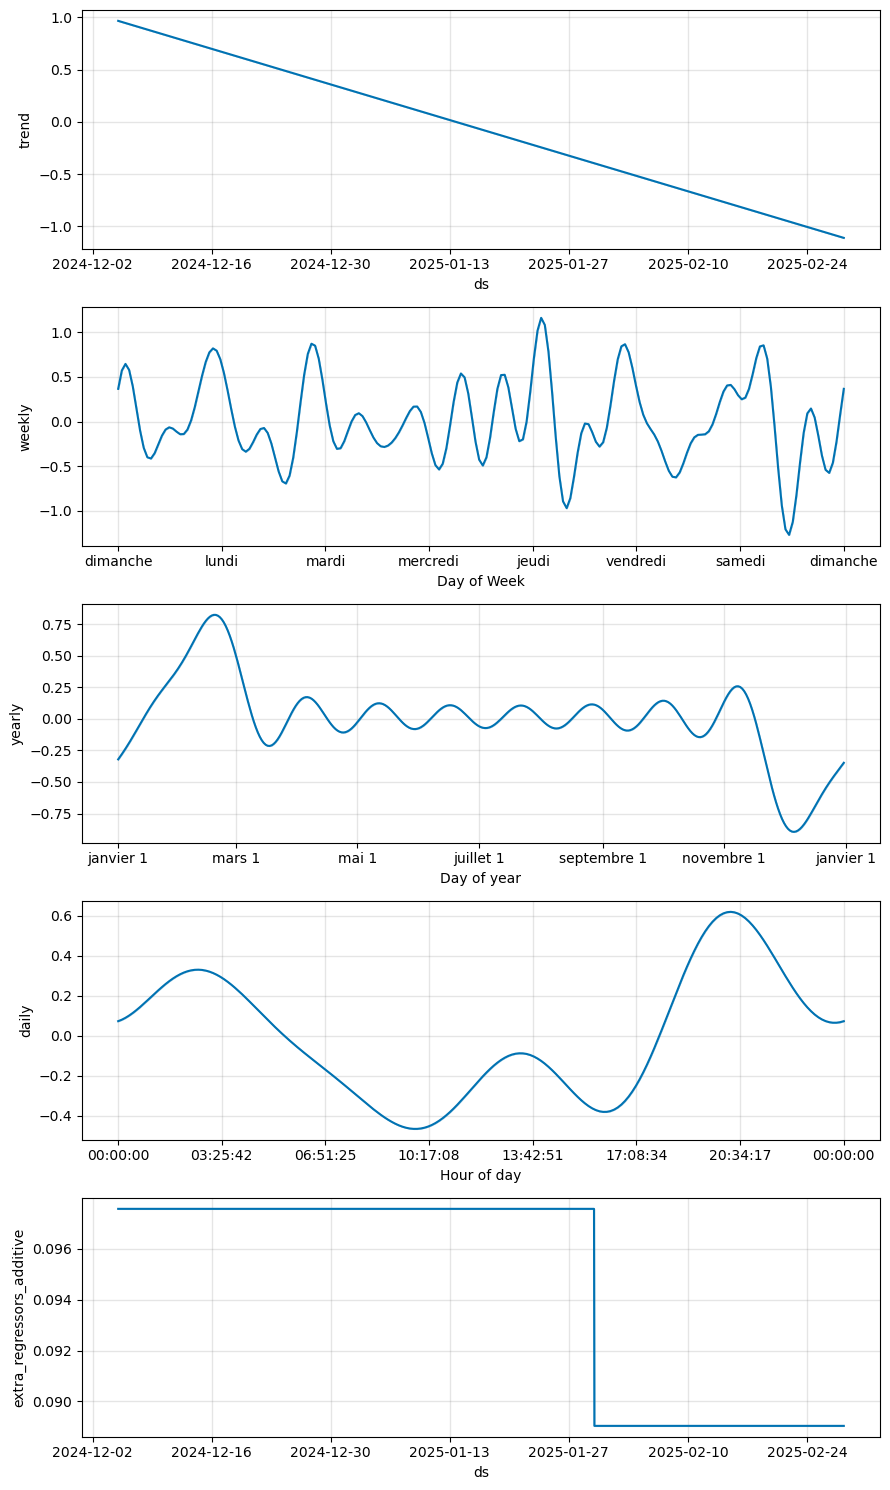

In [ ]:
# Train models for the 5 most active stations
results = train_multiple_station_models(df_prophet, top_n=5)

# Compare the performance
comparison_plot, metrics_df = compare_performance(results)
comparison_plot.savefig('../results/performance_comparison.png')

# For the best station, visualize predictions and components
best_station = metrics_df.iloc[0]['Station']
best_model = results[best_station]['model']
best_forecast = results[best_station]['forecast']

# Visualize predictions
df_station = df_prophet[df_prophet['station'] == best_station]
prediction_plot = plot_predictions(df_station, best_forecast, best_station)
prediction_plot.savefig(f'../results/predictions_station_{best_station}.png')

# Analyze components
components_plot = analyze_components(best_model, best_forecast)
components_plot.savefig(f'../results/components_station_{best_station}.png')

print("Analysis completed successfully!")


Training on 1881 rows, testing on 471 rows.


17:04:59 - cmdstanpy - INFO - Chain [1] start processing
17:04:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


c:\Users\Louise\miniconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\Louise\miniconda3\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavi

Performance for station 82328045:
MAE = 2.13
RMSE = 2.94


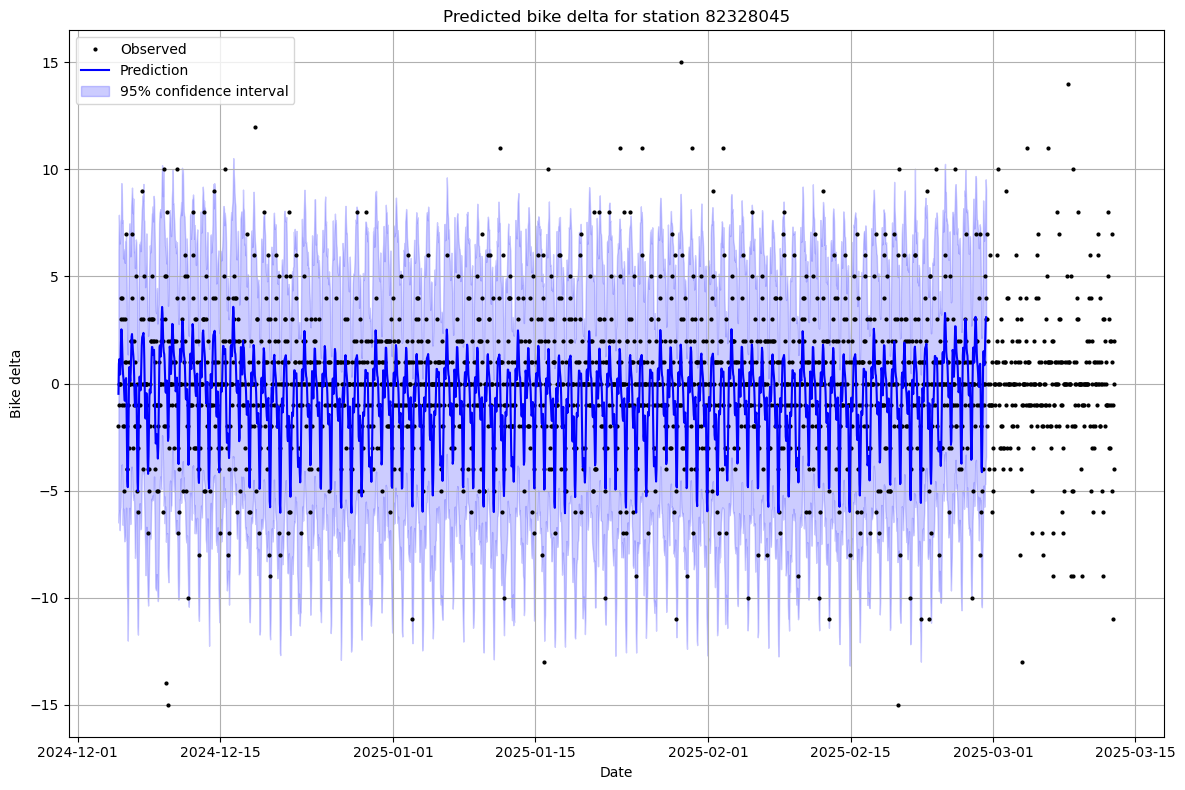

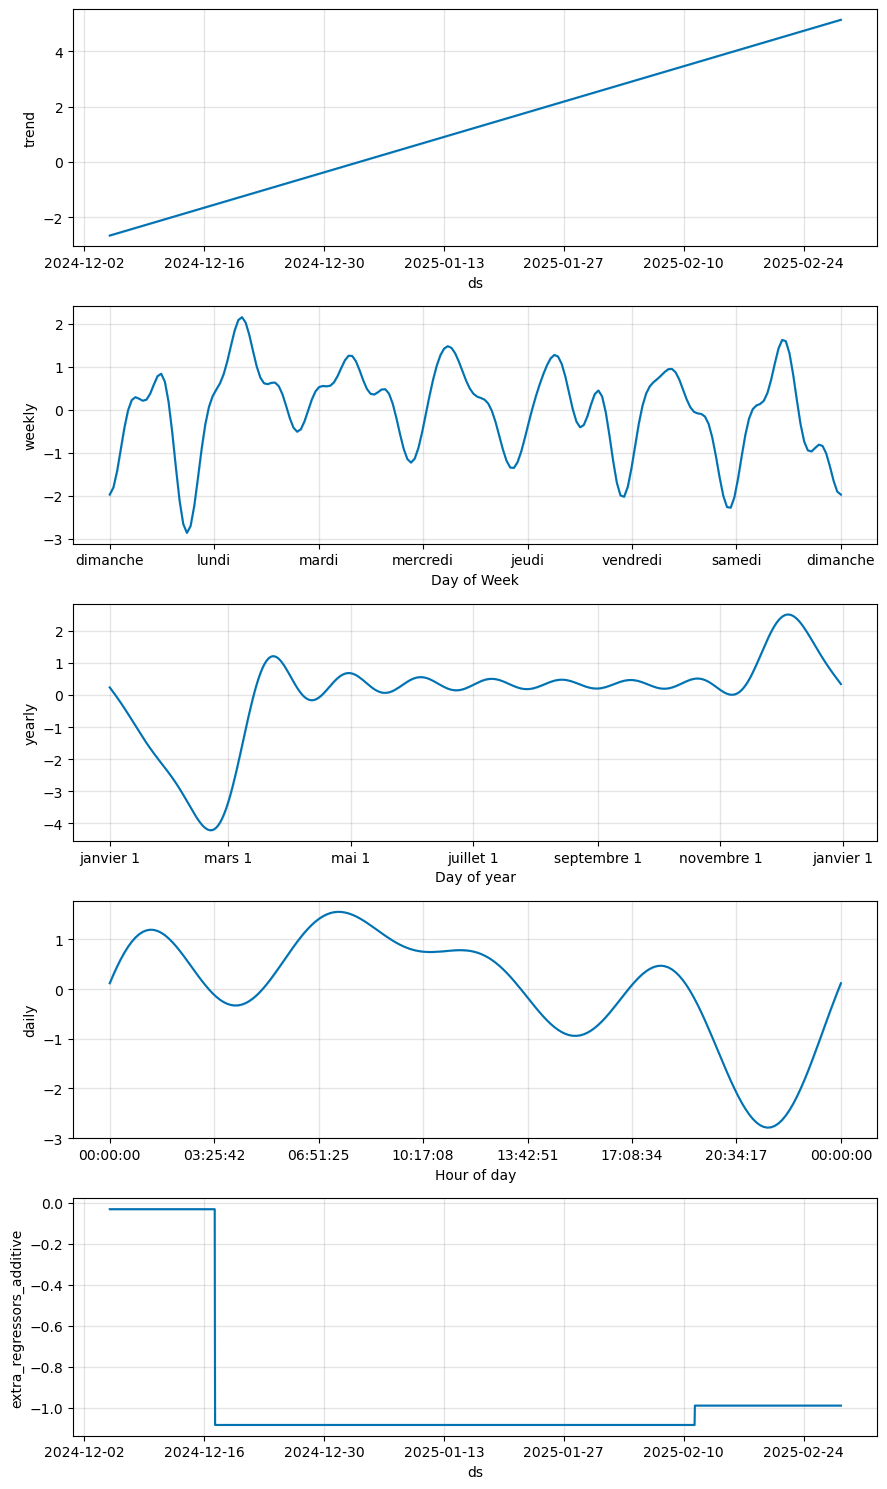

In [19]:
# Train the model for station 82328045
station_id = 82328045
model, forecast, mae, rmse = train_by_station(df_prophet, station_id)

# Filter the original dataframe for that station
df_station = df_prophet[df_prophet['station'] == station_id]

# Plot predictions
plot_predictions = plot_predictions(df_station, forecast, station_id)
plot_predictions.savefig(f'../results/predictions_station_{station_id}.png')

# Plot model components
plot_components = analyze_components(model, forecast)
plot_components.savefig(f'../results/components_station_{station_id}.png')

# Display error metrics
print(f"Performance for station {station_id}:")
print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
